# Phenology exploration

## Background

Phenology is the study of plant and animal life cycles in the context of the seasons. It can be useful in understanding the life cycle trends of crops and how the growing seasons are affected by changes in climate.

DE Africa provides time series EO data and derived services that can be used for phenology studies. 
For our machine learning classification model, we will reply on both the spectral and temporal information to distinguish between different crop types.
Understanding the phenology of the crop types we aim to map will help to determine input features we will use to build an effective classifier.

## Description

In this notebook, we will use DE Africa's [Monthly NDVI and Anomalies service](https://docs.digitalearthafrica.org/en/latest/data_specs/NDVI_Anomaly_specs.html) to explore the phenology of different crop types. We will demonstrate how to query and load the monthly mean NDVI and visualise the phenology curves to help understand the phenology of different crop types.

This service, developed using harmonized Landsat 5,7,and 8 satellite imagery, provides an estimate of vegetation condition for each calendar month. Mean and standard deviation NDVI climatologies are produced for each calender month, using a temporal baseline period from 1984-2020. 

## Getting started

To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell.

## Load packages

In [1]:
%matplotlib inline

import os
import numpy as np
import xarray as xr
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from datetime import datetime

import datacube
from deafrica_tools.classification import collect_training_data
from odc.io.cgroups import get_cpu_quota

/usr/local/lib/python3.8/dist-packages/geopandas/_compat.py:112: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.10.3-CAPI-1.16.1). Conversions between both will be slow.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/dask/dataframe/utils.py:367: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)
/usr/local/lib/python3.8/dist-packages/dask/dataframe/utils.py:367: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)
/usr/local/lib/python3.8/dist-packages/dask/dataframe/utils.py:367: FutureWarning: pandas.UInt64Index is deprecated and will be removed from pa

## Load training data

First, we load the locations of the labeled polygons.

In [2]:
# Point to crop type training data
input_folder="Results/Labels"
output_folder="Results/Phenology"
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

output_crs="EPSG:6933"
path= os.path.join(input_folder,"Cash_crop_type_subset_single_crops_merged.shp")
gpd_crop_types = gpd.read_file(path).to_crs(output_crs)
gpd_crop_types.head()

,year,Crop_type,geometry
0,2021,Maize,"POLYGON ((3280425.252 -2409501.264, 3280415.15..."
1,2021,Maize,"POLYGON ((3280689.817 -2409502.893, 3280704.76..."
2,2021,Sesame,"POLYGON ((3529816.669 -2109463.643, 3529807.92..."
3,2021,Maize,"POLYGON ((3280542.444 -2408144.561, 3280512.19..."
4,2021,Maize,"POLYGON ((3301561.584 -2393086.954, 3301569.64..."


In [3]:
gpd_crop_types["Crop_type"].unique()

array(['Maize', 'Sesame', 'Soy', 'Others'], dtype=object)

## Load monthly NDVI

We then query the DE Africa Open Data Cube API for available monthly NDVI data and load the data for each crop class.

> To match the crop calender of Mozambique, we will explore observations from Oct 2020 to September 2021 (inclusive).
The NDVI product is provided at a spatial resolution of 30 meter.

In [4]:
# define generic query parameters, not including a location
query = {
    'time': ("2021-10","2022-09"),
    'measurements': ['ndvi_mean'],
    'output_crs': output_crs,
    'resolution': (-30, 30)
}
# define a function to feature layers
def feature_layers(query): 
    #connect to the datacube
    dc = datacube.Datacube(app='NDVI_anomaly')
    ds = dc.load(product="ndvi_anomaly",
                  group_by='solar_day',
                  **query)
    # stack multi-temporal measurements and rename them
    n_time=ds.dims['time']
    list_measurements=list(ds.keys())
    ds_stacked=None
    for j in range(len(list_measurements)):
        for k in range(n_time):
            variable_name=list_measurements[j]+'_'+str(k)
            measure_single=ds[list_measurements[j]].isel(time=k).rename(variable_name)
            if ds_stacked is None:
                ds_stacked=measure_single
            else:
                ds_stacked=xr.merge([ds_stacked,measure_single],compat='override')
    return ds_stacked

We use the `collect_training_data()` function to load the NDVI time series for each crop class into a data frame and save the tabulated output.
The function will load data from all pixels within a polygon and calculate the zonal mean.

> This process takes around 10 minutes to run for the full sample. For testing, we will select a subsample to check.

In [5]:
subsample = False

In [6]:
%%time

# Loop through classes ['maize','sesame','soy','others']
class_fields = list(gpd_crop_types["Crop_type"].unique())
NDVIs_all = []
# Collect the training data
for class_field in class_fields:
    print('extracting data for ', class_field)
    single_crops_subset = gpd_crop_types[gpd_crop_types["Crop_type"] == class_field]
    single_crops_subset[class_field] = 1
    single_crops_subset.reset_index(inplace=True)
    if subsample:
        n_subset = 10
        n_sample = len(single_crops_subset)
        if n_sample > n_subset:
            subset = np.random.choice(
                single_crops_subset.index.values, n_subset)
            single_crops_subset = single_crops_subset.loc[subset]
            single_crops_subset.reset_index(inplace=True)
    column_names, model_input = collect_training_data(
        gdf=single_crops_subset,
        dc_query=query,
        ncpus=round(get_cpu_quota()),
        field=class_field,
        zonal_stats='mean',
        feature_func=feature_layers,
    )
    output_file = os.path.join(
        output_folder, 'crop_types_monthly_NDVI_'+class_field+'.txt')
    # grab all columns
    model_col_indices = [column_names.index(
        var_name) for var_name in column_names]
    # Export files to disk
    np.savetxt(output_file, model_input[:, model_col_indices], header=" ".join(
        column_names), fmt="%4f")
    # append to list
    NDVIs_all.append(model_input[:, 1:].T)

extracting data for  Maize
Taking zonal statistic: mean


/usr/local/lib/python3.8/dist-packages/geopandas/geodataframe.py:1472: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/usr/local/lib/python3.8/dist-packages/geopandas/geodataframe.py:1472: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


  0%|          | 0/60 [00:00<?, ?it/s]

Percentage of possible fails after run 1 = 0.0 %
Removed 14 rows wth NaNs &/or Infs
Output shape:  (46, 13)
extracting data for  Sesame
Taking zonal statistic: mean


/usr/local/lib/python3.8/dist-packages/geopandas/geodataframe.py:1472: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/usr/local/lib/python3.8/dist-packages/geopandas/geodataframe.py:1472: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


  0%|          | 0/53 [00:00<?, ?it/s]

Percentage of possible fails after run 1 = 5.66 %
Recollecting samples that failed


  0%|          | 0/3 [00:00<?, ?it/s]

Percentage of possible fails after run 2 = 5.66 %
Recollecting samples that failed


  0%|          | 0/3 [00:00<?, ?it/s]

Percentage of possible fails after run 3 = 5.66 %
Recollecting samples that failed


  0%|          | 0/3 [00:00<?, ?it/s]

Removed 8 rows wth NaNs &/or Infs
Output shape:  (45, 13)
extracting data for  Soy
Taking zonal statistic: mean


/usr/local/lib/python3.8/dist-packages/geopandas/geodataframe.py:1472: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/usr/local/lib/python3.8/dist-packages/geopandas/geodataframe.py:1472: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


  0%|          | 0/13 [00:00<?, ?it/s]

Percentage of possible fails after run 1 = 0.0 %
Removed 5 rows wth NaNs &/or Infs
Output shape:  (8, 13)
extracting data for  Others
Taking zonal statistic: mean


/usr/local/lib/python3.8/dist-packages/geopandas/geodataframe.py:1472: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/usr/local/lib/python3.8/dist-packages/geopandas/geodataframe.py:1472: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


  0%|          | 0/110 [00:00<?, ?it/s]

Percentage of possible fails after run 1 = 2.73 %
Recollecting samples that failed


  0%|          | 0/3 [00:00<?, ?it/s]

Percentage of possible fails after run 2 = 2.73 %
Recollecting samples that failed


  0%|          | 0/3 [00:00<?, ?it/s]

Percentage of possible fails after run 3 = 2.73 %
Recollecting samples that failed


  0%|          | 0/3 [00:00<?, ?it/s]

Removed 7 rows wth NaNs &/or Infs
Output shape:  (103, 13)
CPU times: user 2.01 s, sys: 1.59 s, total: 3.6 s
Wall time: 2min 7s


## Visualize the NDVI phenology curves

We first plot the NDVI curves for all polygons for each class. This shows significant variability exisits within each crop class. Some outliers may be due to incorrect labels.

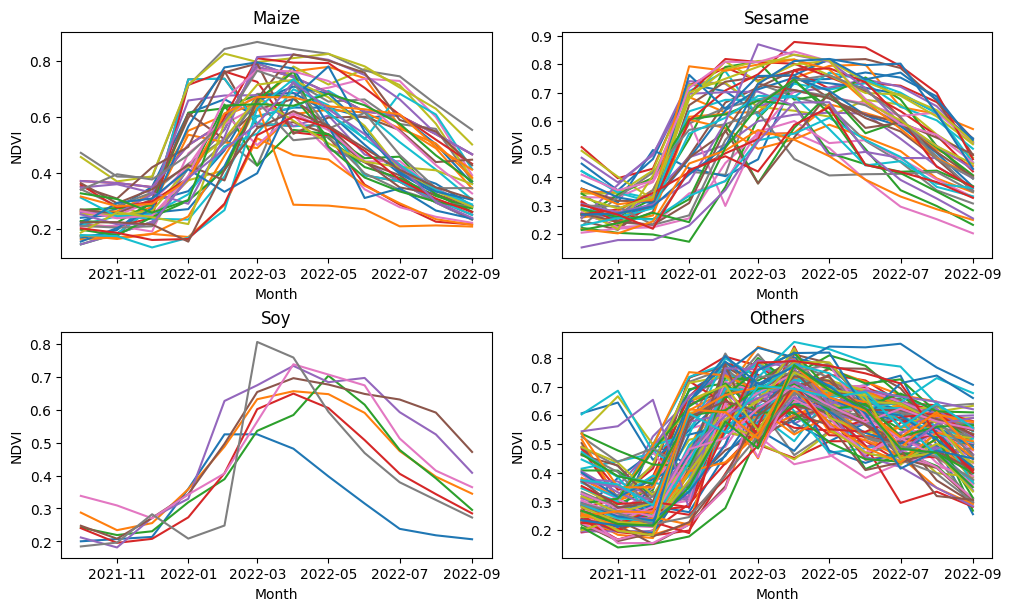

In [7]:
fig, axs = plt.subplots(2, 2, figsize=(10, 6), layout='constrained')
x_labels = np.array(pd.date_range(query["time"][0], query["time"][1], freq='m')).astype('datetime64[M]')
x_labels = np.append(x_labels, x_labels[-1]+1)
for ax,class_field,NDVIs in zip(axs.flat,class_fields,NDVIs_all):
    ax.plot(x_labels,NDVIs)
    ax.set_title(class_field)
    ax.set_xlabel('Month')
    ax.set_ylabel('NDVI')

To better identify patterns and investigate separablity of the crop classes, we will calculate and plot the median NDVIs for each class. 

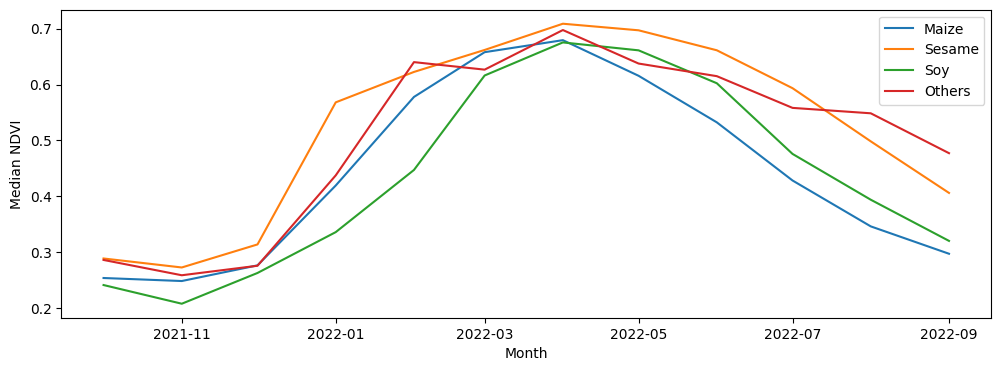

In [8]:
plt.figure(figsize=(12,4))
for class_field,NDVIs in zip(class_fields,NDVIs_all):
    plt.plot(x_labels,np.median(NDVIs,axis=1),label=class_field)
plt.xlabel("Month")
plt.ylabel("Median NDVI")
plt.legend()
plt.show()

As shown above, the median phenology curves are different for the four crop classes, so we know the phenology information is useful to distinguish the classes.

Alternatively, we can compare the mean phenology curves, or visualize the diveristy of the phenonogy curves by plotting various percentiles of the NDVI values for each month and crop class.

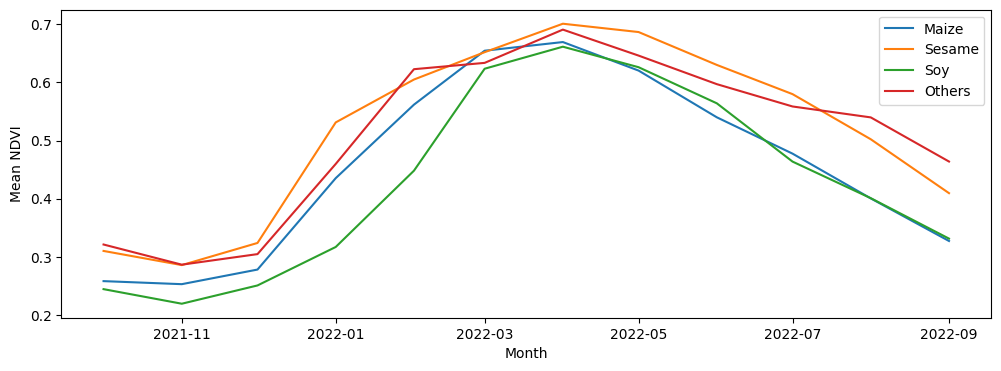

In [9]:
plt.figure(figsize=(12,4))
for class_field,NDVIs in zip(class_fields,NDVIs_all):
    plt.plot(x_labels,np.mean(NDVIs,axis=1),label=class_field)
plt.xlabel("Month")
plt.ylabel("Mean NDVI")
plt.legend()
plt.show()

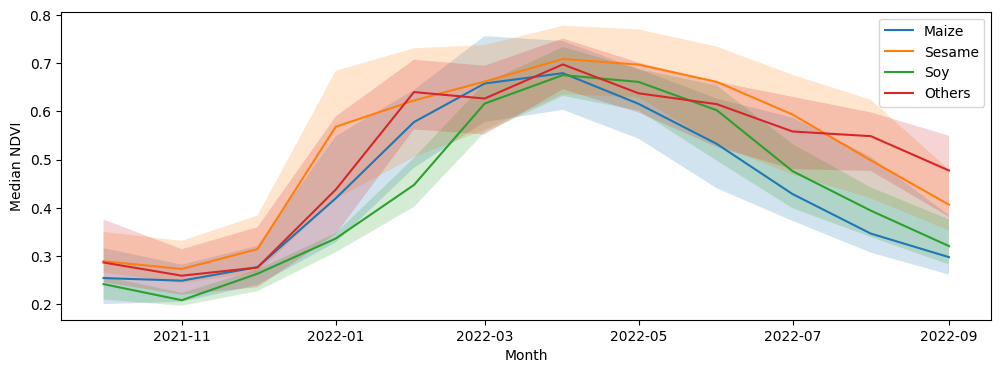

In [10]:
plt.figure(figsize=(12,4))
for class_field, NDVIs in zip(class_fields,NDVIs_all):
    ndvi_perc= np.percentile(NDVIs, [25, 50, 75] ,axis=1)
    
    plt.plot(x_labels,ndvi_perc[1],label=class_field)
    plt.fill_between(x_labels, ndvi_perc[0],  ndvi_perc[2], alpha=.2)

plt.xlabel("Month")
plt.ylabel("Median NDVI")
plt.legend()
plt.show()